# NN network for corresponding 

**Motivation:** This scripts aims to model a neural network model with same input parameters as logistic regression model (step, Lasso, ridge)
The architecture is chose as 

In [1]:
final_model_dict = {}

### Load

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## NN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR
import shap

# local
import set_path
import supp.support_load as sl
import supp.support_get_mapping as gm
from supp.support_analyze_model import GraphPlotter, plot_cdf, plot_roc, reliability_plot
from supp.support_save import save_df
from supp.support_model_nn import BinaryClassifier, save_nn_info
from supp.support_model_glm import get_model_coef_df, get_model_coef_dict
from supp.support_model_stats import find_viziers_above_overlap, find_non_viziers_in_overlap, find_viziers_in_overlap, find_persons_in_overlap

#### Load train, validation adn test set

In [3]:
# Load train, validation and test set
data_train = sl.read_csv('df_vizier_train_v2_2')
data_val = sl.read_csv('df_vizier_val_v2_2')
# set 'ID_person' as index
data_train.set_index('ID_person', inplace=True)
data_val.set_index('ID_person', inplace=True)

# Set response
response = 'vizier'
features_all = [col for col in data_train.columns if col != response]

# conver X to numpy
X_train0 = data_train[features_all].to_numpy()
X_val0 = data_val[features_all].to_numpy()
# conver y to numpy
y_train0 = data_train[response].to_numpy()
y_val0 = data_val[response].to_numpy()

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_train_v2_2.csv
CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_val_v2_2.csv


In [4]:
# Check loaded data shape
print(data_train.shape)
print(data_val.shape)

(2684, 55)
(575, 55)


In [5]:
# Check features data shape
print(X_train0.shape)
print(X_val0.shape)

(2684, 54)
(575, 54)


In [6]:
# Check response data shape
print(y_train0.shape)
print(y_val0.shape)

(2684,)
(575,)


In [7]:
# Check count of viziers
print(y_train0.sum())
print(y_val0.sum())

52
11


#### Get feature names from GLM models

In [8]:
# Get dataframe with all GLM coefficients
df_coef = get_model_coef_df(version='_v2')
df_coef

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_model_coefficients_v0_v2.xlsx


Variable,wr 5 (m) pr 9Hwty,HAty-a,iwn knmwt,iry-pat,zA ncwt n Xt.f,imy-rA Snwty,imy-rA kAt nbt (nt) ncwt,father_was_vizier,PC2,dynasty_1,...,r P nb,xrp aH,cmr waty,Hry-cStA,imy iz,Xry-Hbt,[imAxw xr] nTr aA,imAxw,imA-a,wt(y) Inpw
step_glm,3.751070,3.611850,3.136970,3.074980,2.849930,2.792770,2.692830,1.263980,0.118540,0.086920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lasso_glm,3.761450,3.584521,2.515640,2.611412,1.716848,1.908989,2.705117,0.970104,-0.007594,-0.111677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ridge_glm,1.283847,1.010631,0.569711,1.075314,0.873841,0.724909,0.852368,0.051945,-0.004667,-0.006631,...,0.221762,0.22014,0.218525,0.169459,0.167875,0.125974,0.094048,0.048569,0.048382,-0.012974


In [9]:
# Get feature names for each GLM model
coef_step = get_model_coef_dict('step_glm', df=df_coef)
coef_lasso = get_model_coef_dict('lasso_glm', df=df_coef)
coef_ridge = get_model_coef_dict('ridge_glm', df=df_coef)

In [10]:
# Define set of features for each model
omit_features = ['(Intercept)']
features_step = [key for key in coef_step.keys() if key not in omit_features]
features_lasso = [key for key in coef_lasso.keys() if key not in omit_features]
features_ridge = [key for key in coef_ridge.keys() if key not in omit_features]

In [ ]:
required_features = ['father_was_vizier', 'PC2', 'dynasty_1']
features_step += [el for el in required_features and el not in features_step]
features_lasso += [el for el in required_features and el not in features_lasso]
features_ridge += [el for el in required_features and el not in features_ridge]

In [11]:
# Check features len
print(len(features_all))
print(len(features_step))
print(len(features_lasso))
print(len(features_ridge))

54
10
14
40


In [12]:
print(list(coef_step.keys()))
print(list(coef_lasso.keys()))
print(list(coef_ridge.keys()))

['wr 5 (m) pr 9Hwty', 'HAty-a', 'iwn knmwt', 'iry-pat', 'zA ncwt n Xt.f', 'imy-rA Snwty', 'imy-rA kAt nbt (nt) ncwt', 'father_was_vizier', 'PC2', 'dynasty_1', '(Intercept)']
['wr 5 (m) pr 9Hwty', 'HAty-a', 'iwn knmwt', 'iry-pat', 'zA ncwt n Xt.f', 'imy-rA Snwty', 'imy-rA kAt nbt (nt) ncwt', 'father_was_vizier', 'PC2', 'dynasty_1', '(Intercept)', 'zA ncwt n Xt.f cmcw', 'Hry-cStA n wD(t)-mdw nbt nt ncwt', 'imy-rA prwy-HD', 'Xry-Hbt Hry-tp']
['wr 5 (m) pr 9Hwty', 'HAty-a', 'iwn knmwt', 'iry-pat', 'zA ncwt n Xt.f', 'imy-rA Snwty', 'imy-rA kAt nbt (nt) ncwt', 'father_was_vizier', 'PC2', 'dynasty_1', '(Intercept)', 'zA ncwt n Xt.f cmcw', 'Hry-cStA n wD(t)-mdw nbt nt ncwt', 'imy-rA prwy-HD', 'Xry-Hbt Hry-tp', 'mDH ncwt qd(w) m prwy', 'imy-rA gc-pr', 'mDH zS(w) ncwt', 'imy iz Nxn', 'imy-rA izwy (n) Xkr(w) ncwt', 'aD-mr 8p', 'xtm(ty)-bity', 'xrp SnDt nbt', 'imy-rA 5maw', 'zS mDAt-nTr', 'zA ncwt', 'Hry-cStA n pr-dwAt', 'aA 8wAw', 'Xry-tp ncwt', 'imAxw xr Wcir', 'imy-rA prwy-nbw', 'r P nb', 'xrp 

In [13]:
# this title was removed in GLM because of high VIF
set(features_all) - set(features_ridge)

{'Hry-tp Nxb',
 'Htc(?) Inpw',
 'PC1',
 'aD-mr (n) zAb',
 'cm / ctm',
 'cmcw cnwt',
 'dynasty_0',
 'dynasty_2',
 'imy-rA wabty',
 'imy-rA zS(w) a(w) (nw) ncwt',
 'mdw rxyt',
 'mniw Nxn / zAw Nxn',
 'xrp (i)m(yw) nTrw',
 'xrp iAwt nbwt nTrwt'}

### Train function

In [14]:
# define hidden_size
# (can be overwriten later)
hidden_size = [2]

In [15]:
# Define the weight of positive examples
sum_vizier = y_train0.sum() 
sum_non_vizier = y_train0.shape[0] - sum_vizier
pos_weight = sum_non_vizier / sum_vizier
pos_weight = 1
pos_weight = torch.tensor([pos_weight], dtype=torch.float32)
# Set criterion
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Using BCEWithLogitsLoss

pos_weight

tensor([1.])

In [37]:
def train_nn(params):
    """
    This funtion serves as main method for training NN model
        - defines model
        - defines optimizer
        - carry the training process
        - choose the best model via early stopping
        - calc train and vall loss
        - plot evolution of loss
        - saves final model
        
    Parameters:
        params (dict): hyperparameters of the NN model
    """
    print(f'===================================')
    print(f' S T A R T I N G   M O D E L')
    print(f'===================================\n')
    current_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Set params
    typ = params['typ']
    batch_size = params['batch_size']
    hidden_size = params['hidden_size']
    activation_name = params['activation_name']
    dropout_prob = params['dropout_prob']
    optimizer_name = params['optimizer_name']
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    patience = params['patience']
    weight_decay_value = params['l2_lambda']

    # Set features space
    features = {'step': features_step,
                'lasso': features_lasso,
                'ridge': features_ridge
               }[typ]
    X_train = data_train[features].to_numpy()
    X_val = data_val[features].to_numpy()
    
    # Converting data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_train = torch.tensor(y_train0, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val0, dtype=torch.float32).unsqueeze(1)
    
    # Prepare datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    input_size = X_train.shape[1]
    # Define model, loss function and optimizer
    model = BinaryClassifier(input_size, hidden_size, activation_name, dropout_prob=dropout_prob)
    
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
    print(f'Defined BinaryClassifier with {criterion=}')
    print(f'Defined BinaryClassifier with {optimizer=}')

    # Print model architecture
    print(f'\n===================================')
    print(f'MODEL ARCHITECTURE:\n{model}')
    print(f'===================================\n')
    
    # Declare losses
    train_losses = []
    val_losses = []
    pio_list = []     # persons in overlap
    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0

    # Flag for learning rate reduce
    lr_reduced_1 = False 
    lr_reduced_2 = False 
    # Train the model
    for epoch in range(epochs):

        # Training step
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        # Compute average train loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        y_true = []
        y_hat = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                # Get y_true and y_hat batch
                y_true.extend([el.item() for el in batch_y])
                probabilities = torch.sigmoid(outputs)
                y_hat.extend([el.item() for el in probabilities])
        # Compute average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        # Compute persons in overlap
        col = 'probs'
        df_probs= pd.DataFrame({'vizier': y_true, col: y_hat})
        pio = find_persons_in_overlap(df_probs, col)
        pio_list.append(pio)
    
        # Print current epoch performance
        print(
            f"Epoch {epoch+1}/{epochs},\t"
            f"Train Loss: {train_loss:.4f},\t"
            f"Validation Loss: {val_loss:.4f},\t"
            #f"LR: {scheduler.get_last_lr()[0]:.6f}"
        )
    
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), rf'nn_models\best_mlp_{typ}_v2.pth')
        else:
            patience_counter += 1
            print(f"\tEarly stopping patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("\tEarly stopping triggered. Stopping training.")
                break
        
        # Update learing rate
        if val_loss < 0.02 and not lr_reduced_1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 5
            print(f"Learning rate reduced to: {param_group['lr']}")
            lr_reduced_1 = True
        # if val_loss < 0.061 and not lr_reduced_2:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = param_group['lr'] / 10
        #     print(f"Learning rate reduced to: {param_group['lr']}")
        #     lr_reduced_2 = True

        # Update learing rate
        #scheduler.step()
    
    # Load the best model after early stopping
    model.load_state_dict(torch.load(rf'nn_models\best_mlp_{typ}_v2.pth'))
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()
    # Plot evolutio of persons in overlap
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(val_losses)+1), pio_list, label='Persons in overlap')
    plt.xlabel('Epochs')
    plt.ylabel('Persons in overlap')
    plt.title('Evolution of Persons in Overlap')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Save the model
    path_save = rf'nn_models\mlp_{typ}_{current_time}.pth'
    torch.save(model.state_dict(), path_save)
    save_nn_info(input_size, hidden_size, activation_name, features, path_save)


    # print model lacation
    print(f'\n\n===================================')
    print(f' M O D E L   L O C A T I O N :')
    print(f'{path_save}')
    print(f'===================================\n')
    final_model_dict[typ] = path_save

    # print model lacation
    print(f'\n\n===================================')
    print(f' persons_in_overlap: {pio_list[-1]}')
    print(f'===================================\n')

    model.eval()
    return model, val_loader

In [17]:
def plot_shaps(model, features_set, output_path=None):
    # Prepare data
    X_df = data_train[features_set]
    X_df = X_df.sample(frac=1, random_state=42).reset_index(drop=True)
    X_explain = torch.tensor(X_df.values, dtype=torch.float32)
    X_sample = X_explain[:150]
    
    # Choose Explainer
    model.eval()
    explainer = shap.GradientExplainer(model, X_sample)
    # Calculate SHAP values
    shap_values_step = explainer.shap_values(X_explain)
    # Remove the last dimension
    shap_values_step = shap_values_step.squeeze(-1)
    
    # Plot and save SHAP 
    plt.figure()
    shap.summary_plot(shap_values_step, X_explain.numpy(), feature_names=features_set, show=False)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(f'{output_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{output_path}.pdf', bbox_inches='tight')
    plt.show()

In [18]:
def print_stats(model, val_loader, params):
    # Validation step
    model.eval()
    val_loss = 0.0
    y_true = []
    y_hat = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            # Get y_true and y_hat batch
            y_true.extend([el.item() for el in batch_y])
            probabilities = torch.sigmoid(outputs)
            y_hat.extend([el.item() for el in probabilities])
    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    # Compute persons in overlap
    col = 'probs'
    df_probs= pd.DataFrame({'vizier': y_true, col: y_hat})
    pio_val = find_persons_in_overlap(df_probs, col)
    mean_vizier = df_probs.loc[df_probs['vizier']==1, col].mean()
    mean_non_vizier = df_probs.loc[df_probs['vizier']==0, col].mean()
    bottom_3_vizier = df_probs.loc[df_probs['vizier']==1, col].sort_values().to_list()[3]
    top_3_non_vizier = df_probs.loc[df_probs['vizier']==0, col].sort_values().to_list()[-3]
    
    print(params)
    print(f"Validation Loss:\t{val_loss:.4f}")
    print(f"Mean vizier:\t\t{mean_vizier:.4f}")
    print(f"Mean non-vizier:\t{mean_non_vizier:.4f}")
    print(f"bottom_3_vizier:\t{bottom_3_vizier:.4f}")
    print(f"top_3_non_vizier:\t{top_3_non_vizier:.4f}")
    print(f"PiO Validation:\t\t{pio_val}")

### Step NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.6929,	Validation Loss: 0.6670,	
Epoch 2/1000,	Train Loss: 0.6491,	Validation Loss: 0.6252,	
Epoch 3/1000,	Train Loss: 0.6085,	Validation Loss: 0.5861,	
Epoch 4/1000,	Train Loss: 0.5710,	Validation Loss: 0.5502,	
Epoch 5/1000,	Train Loss: 0.5363,	Validation Loss: 0.5172,	
Epoch 6/1000,	Train Loss: 0.5044,	Validation Loss: 0.4867,	
Epoch 7/1000,	Train Loss: 0.4752,	Validation Loss: 0.4586,	
Epoch 8/1000,	Train Loss: 0.4484,	Validation Loss: 0.4329,	
Epoch 9/1000,	Train Loss: 0.4238,	Validati

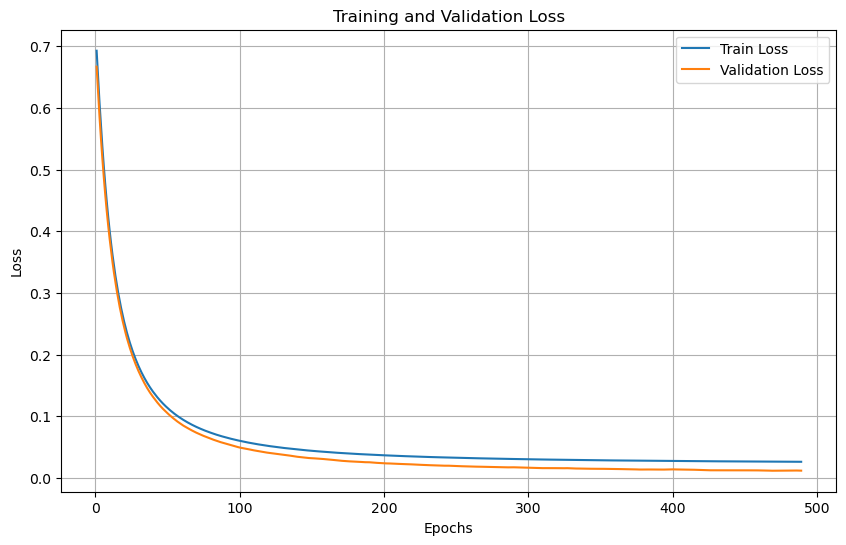

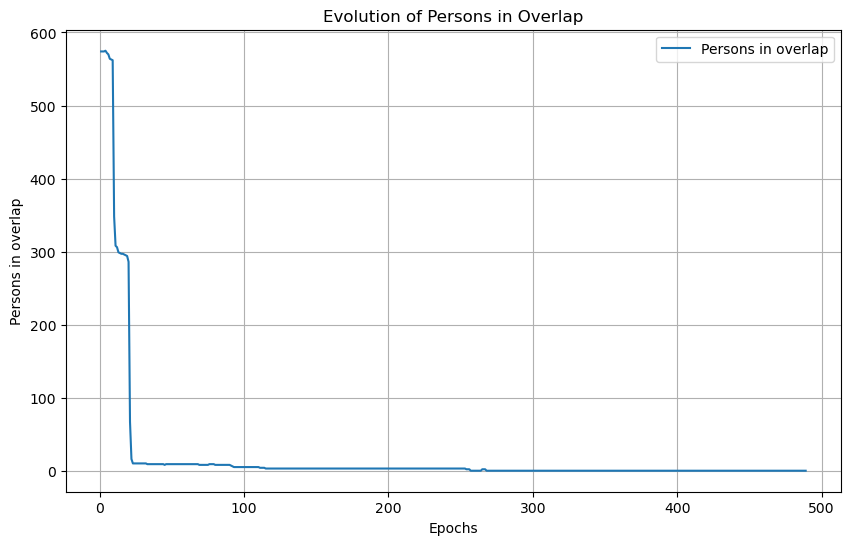



 M O D E L   L O C A T I O N :
nn_models\mlp_step_2025-05-02-23-23-07.pth



 persons_in_overlap: 0



In [19]:
params = {'typ': 'step',
          'batch_size': 512,
          'hidden_size': [],
          'dropout_prob': 0,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.01,
          'patience': 20,
          'l2_lambda': 0
         }
model_step, val_loader_step = train_nn(params)

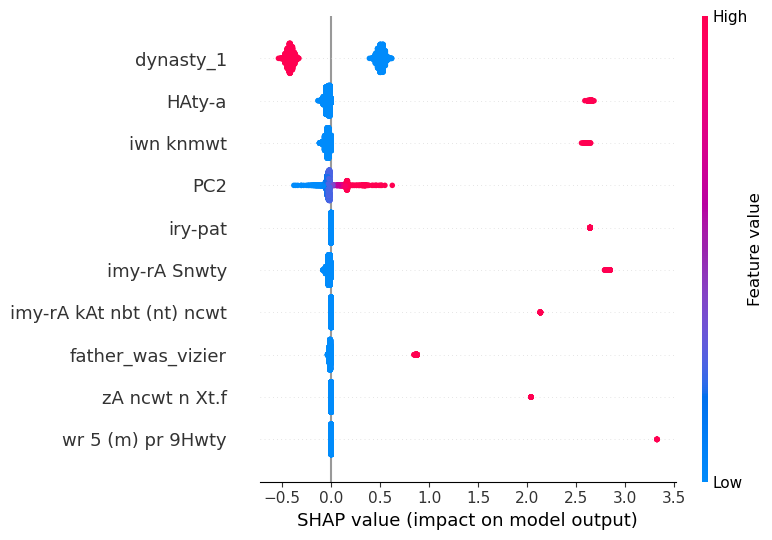

In [20]:
plot_shaps(model_step, features_step)

In [21]:
print_stats(model_step, val_loader_step, params)

{'typ': 'step', 'batch_size': 512, 'hidden_size': [], 'dropout_prob': 0, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.01, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0115
Mean vizier:		0.7804
Mean non-vizier:	0.0053
bottom_3_vizier:	0.8013
top_3_non_vizier:	0.0767
PiO Validation:		0


### Lasso NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.7094,	Validation Loss: 0.6798,	
Epoch 2/1000,	Train Loss: 0.6644,	Validation Loss: 0.6367,	
Epoch 3/1000,	Train Loss: 0.6227,	Validation Loss: 0.5968,	
Epoch 4/1000,	Train Loss: 0.5839,	Validation Loss: 0.5600,	
Epoch 5/1000,	Train Loss: 0.5482,	Validation Loss: 0.5259,	
Epoch 6/1000,	Train Loss: 0.5153,	Validation Loss: 0.4946,	
Epoch 7/1000,	Train Loss: 0.4850,	Validation Loss: 0.4658,	
Epoch 8/1000,	Train Loss: 0.4571,	Validation Loss: 0.4393,	
Epoch 9/1000,	Train Loss: 0.4316,	Validati

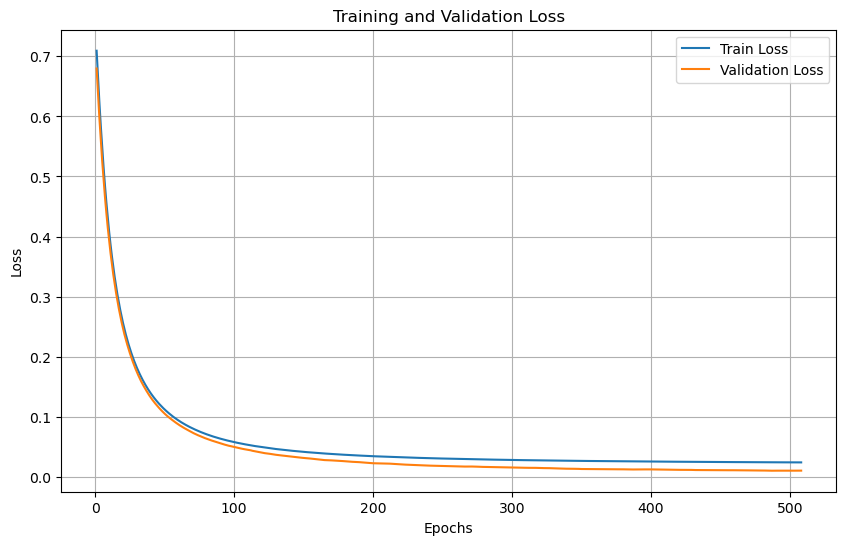

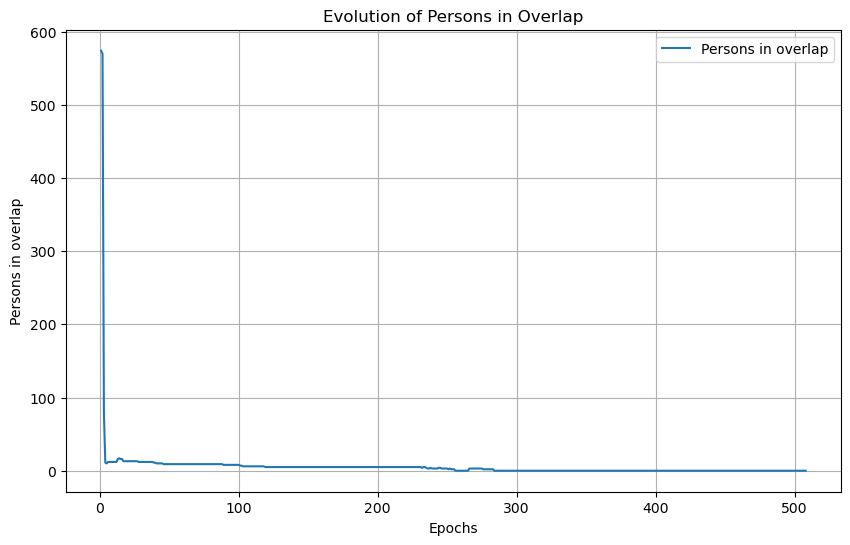



 M O D E L   L O C A T I O N :
nn_models\mlp_lasso_2025-05-02-23-24-07.pth



 persons_in_overlap: 0



In [22]:
params = {'typ': 'lasso',
          'batch_size': 512,
          'hidden_size': [],
          'dropout_prob': 0,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.01,
          'patience': 20,
          'l2_lambda': 0
         }
model_lasso, val_loader_lasso = train_nn(params)

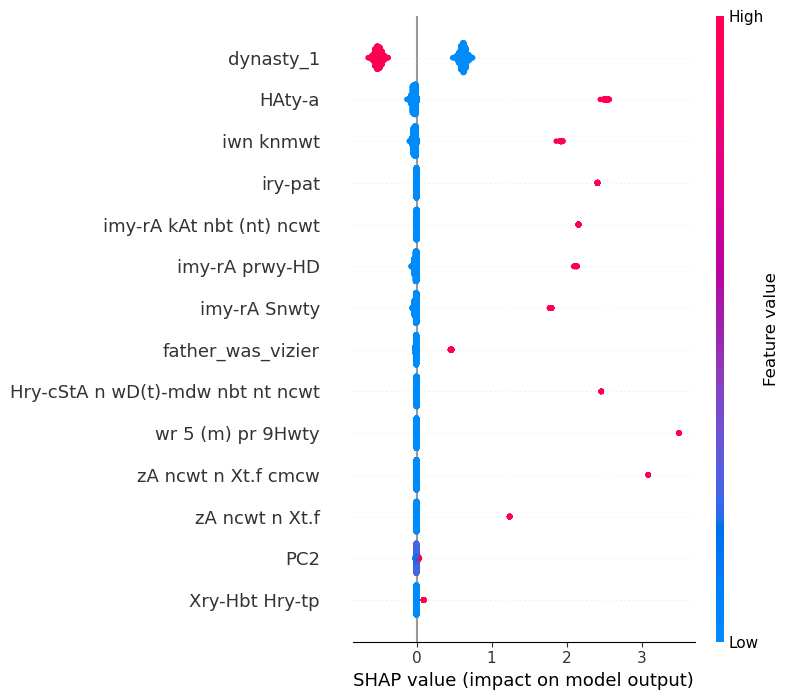

In [23]:
plot_shaps(model_lasso, features_lasso)

In [24]:
print_stats(model_lasso, val_loader_lasso, params)

{'typ': 'lasso', 'batch_size': 512, 'hidden_size': [], 'dropout_prob': 0, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.01, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0100
Mean vizier:		0.8272
Mean non-vizier:	0.0052
bottom_3_vizier:	0.7430
top_3_non_vizier:	0.1823
PiO Validation:		0


### Ridge NN

 S T A R T I N G   M O D E L

Defined BinaryClassifier with criterion=BCEWithLogitsLoss()
Defined BinaryClassifier with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)

MODEL ARCHITECTURE:
BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

Epoch 1/1000,	Train Loss: 0.6906,	Validation Loss: 0.6777,	
Epoch 2/1000,	Train Loss: 0.6713,	Validation Loss: 0.6588,	
Epoch 3/1000,	Train Loss: 0.6524,	Validation Loss: 0.6392,	
Epoch 4/1000,	Train Loss: 0.6310,	Validation Loss: 0.6175,	
Epoch 5/1000,	Train Loss: 0.6092,	Validation Loss: 0.

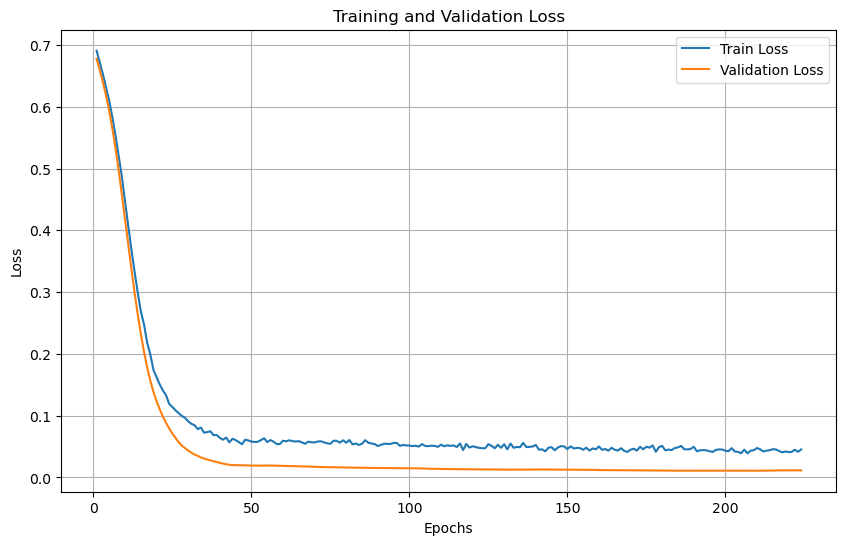

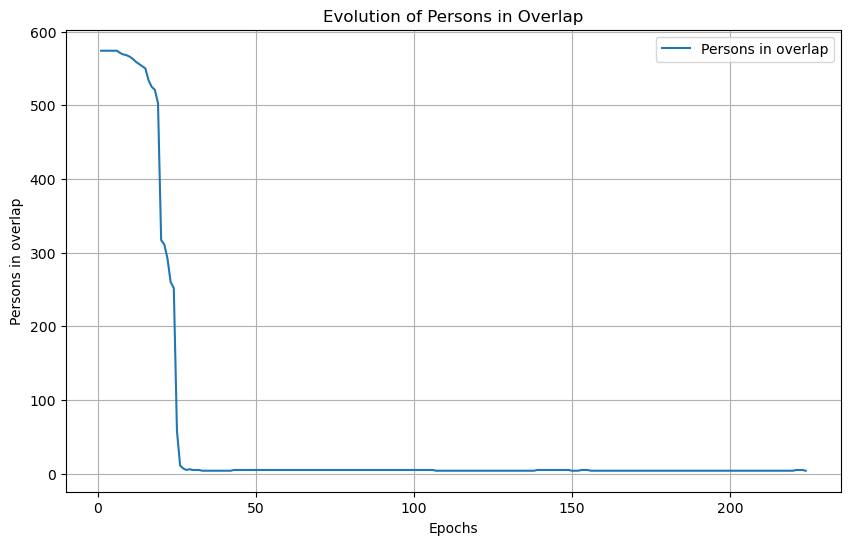



 M O D E L   L O C A T I O N :
nn_models\mlp_ridge_2025-05-03-00-52-29.pth



 persons_in_overlap: 4



In [240]:
params = {'typ': 'ridge',
          'batch_size': 512,
          'hidden_size': [16,4],
          'dropout_prob': 0.2,
          'activation_name': 'relu',
          'optimizer_name': 'adam',
          'epochs': 1000,
          'learning_rate': 0.002,
          'patience': 20,
          'l2_lambda': 0
         }
model_ridge, val_loader_ridge = train_nn(params)

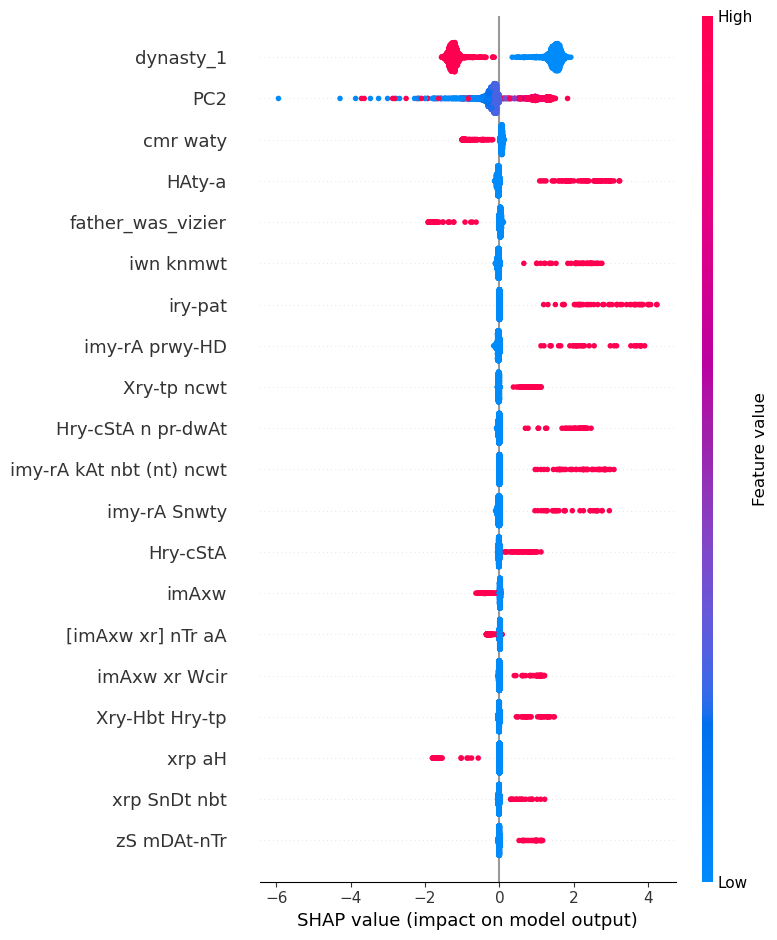

In [241]:
plot_shaps(model_ridge, features_ridge)

In [242]:
print_stats(model_ridge, val_loader_ridge, params)

{'typ': 'ridge', 'batch_size': 512, 'hidden_size': [16, 4], 'dropout_prob': 0.2, 'activation_name': 'relu', 'optimizer_name': 'adam', 'epochs': 1000, 'learning_rate': 0.002, 'patience': 20, 'l2_lambda': 0}
Validation Loss:	0.0109
Mean vizier:		0.7719
Mean non-vizier:	0.0035
bottom_3_vizier:	0.8167
top_3_non_vizier:	0.1166
PiO Validation:		4


### Models summary

In [28]:
# print final_model_list
final_model_dict

{'step': 'nn_models\\mlp_step_2025-05-02-23-23-07.pth',
 'lasso': 'nn_models\\mlp_lasso_2025-05-02-23-24-07.pth',
 'ridge': 'nn_models\\mlp_ridge_2025-05-02-23-25-09.pth'}